# Info

## Authors

- Maximilian Reisecker (11908094)
- Marc Reiterer (12020640)
- Benjamin Luxbacher (11910547)

## Repository

[https://github.com/Mareise/SOS_3](https://github.com/Mareise/SOS_3)

# Code

## Initial imports and basic visualizations

In [2]:
import numpy as np
import pandas as pdcoding
import gzip
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from scipy.spatial.distance import cdist

In [3]:
import math
import matplotlib.lines

#HitHistogram
def HitHist(_m, _n, _weights, _idata):
    hist = np.zeros(_m * _n)
    for vector in _idata: 
        position =np.argmin(np.sqrt(np.sum(np.power(_weights - vector, 2), axis=1)))
        hist[position] += 1

    return hist.reshape(_m, _n)

#U-Matrix - implementation
def UMatrix(_m, _n, _weights, _dim):
    print("m: ", _m, " n: ", _n, " dim: ", _dim)
    U = _weights.reshape(_m, _n, _dim)
    U = np.insert(U, np.arange(1, _n), values=0, axis=1)
    U = np.insert(U, np.arange(1, _m), values=0, axis=0)
    #calculate interpolation
    for i in range(U.shape[0]): 
        if i%2==0:
            for j in range(1,U.shape[1],2):
                U[i,j][0] = np.linalg.norm(U[i,j-1] - U[i,j+1], axis=-1)
        else:
            for j in range(U.shape[1]):
                if j%2==0: 
                    U[i,j][0] = np.linalg.norm(U[i-1,j] - U[i+1,j], axis=-1)
                else:      
                    U[i,j][0] = (np.linalg.norm(U[i-1,j-1] - U[i+1,j+1], axis=-1) + np.linalg.norm(U[i+1,j-1] - U[i-1,j+1], axis=-1))/(2*np.sqrt(2))

    U = np.sum(U, axis=2) #move from Vector to Scalar

    for i in range(0, U.shape[0], 2): #count new values
        for j in range(0, U.shape[1], 2):
            region = []
            if j>0: region.append(U[i][j-1]) #check left border
            if i>0: region.append(U[i-1][j]) #check bottom
            if j<U.shape[1]-1: region.append(U[i][j+1]) #check right border
            if i<U.shape[0]-1: region.append(U[i+1][j]) #check upper border

            U[i,j] = np.median(region)

    return U

#SDH - implementation
def SDH(_m, _n, _weights, _idata, factor, approach):
    import heapq

    sdh_m = np.zeros( _m * _n)

    cs=0
    for i in range(factor): cs += factor-i

    for vector in _idata:
        dist = np.sqrt(np.sum(np.power(_weights - vector, 2), axis=1))
        c = heapq.nsmallest(factor, range(len(dist)), key=dist.__getitem__)
        if (approach==0): # normalized
            for j in range(factor):  sdh_m[c[j]] += (factor-j)/cs 
        if (approach==1):# based on distance
            for j in range(factor): sdh_m[c[j]] += 1.0/dist[c[j]] 
        if (approach==2): 
            dmin, dmax = min(dist[c]), max(dist[c])
            for j in range(factor): sdh_m[c[j]] += 1.0 - (dist[c[j]]-dmin)/(dmax-dmin)

    return sdh_m.reshape(_m, _n)




## Vectorfield visualization function

In [4]:
from collections import namedtuple
Config = namedtuple('Config', 'groups sigma enable_flow enable_borderline scaling_arrow_length')

def visualize_vector_field(_m, _n, _weights, _dim, configs):
    
	fig, axs = plt.subplots(nrows=1, ncols=len(configs))

	for a, conf in enumerate(configs):
		dimensionIndices = np.indices([_dim])[0] 

		arrowColors = ['#0000FF','#00FFFF','#FF00FF']
		borderColors = ['#FF0000','#FFC800','#808080']


		# in order to handle edges, we should to pad the array

		Ustart = _weights.reshape(_m, _n, _dim)
		# mode can be changed

		ax = axs[a]
		
		#U = np.insert(U, np.arange(1, _n), values=0, axis=1)
		#U = np.insert(U, np.arange(1, _m), values=0, axis=0)
		#display(U)

		# groups are 1, 2 or 3
		kernelCounter = -1
		for g in conf.groups:
			kernelCounter += 1        
			
			if len(g) == 0:
				print('nothing in group! ')
				continue
			
			active = np.isin(dimensionIndices,g)
			#display(active)

			if not np.any(active):
				print('group with no valid members!')
				continue   

			# a range just to add some data to the outside     
			kernelRange = 5
		
			
			kernelDiv = 1 / (2 * math.pi * (conf.sigma ** 2))
			kernelExpDiv = 2 * (conf.sigma ** 2)
			

			U = np.pad(Ustart, pad_width=((kernelRange,kernelRange),(kernelRange,kernelRange),(0,0)),mode="reflect")
			
		
			for i in range(_m):
				for j in range(_n):
					#vector = U[i, j, :2]  # Extract 2D vector component

					indices = np.indices([_m + kernelRange * 2,_n + kernelRange * 2])
					distX = indices[0,:,:] - (i + kernelRange)
					distY = indices[1,:,:] - (j + kernelRange)
					distXAbs = np.abs(distX)
					distYAbs = np.abs(distY)
					distBlock = np.maximum(distXAbs, distYAbs)
					
					distSqS = np.power(distXAbs, 2) + np.power(distYAbs, 2)

					distManhat = distXAbs + distYAbs
					blockOk = distBlock <= kernelRange

					# linear dropoff with manhattan distance
					# prevent divide by zero

					kernelFactor = kernelDiv * np.power(np.e,-distSqS/kernelExpDiv)


					xImpact = np.multiply(np.sign(distX), kernelFactor)
					yImpact = np.multiply(np.sign(distY), kernelFactor)
					#display(U[:,:,active])
					#display(np.shape(U[:,:,:]))

					# actual distances
					actualDist = np.sqrt(np.power(U[:,:,active] - U[(i + kernelRange),(j + kernelRange),active],2).sum(axis=2))
					xComponents = np.multiply(actualDist, xImpact)
					yComponents = np.multiply(actualDist, yImpact)
					xPositive = np.sum(np.clip(xComponents,a_min=0,a_max=None))
					xNegative = np.sum(np.clip(xComponents,a_max=0,a_min=None))
					yPositive = np.sum(np.clip(yComponents,a_min=0,a_max=None))
					yNegative = np.sum(np.clip(yComponents,a_max=0,a_min=None))


					xDirection = np.sum(xComponents[blockOk]) * conf.scaling_arrow_length
					yDirection = np.sum(yComponents[blockOk]) * conf.scaling_arrow_length


					angle = math.atan2(xDirection, yDirection)
					length = math.sqrt(xDirection**2 + yDirection**2)/2



					line = matplotlib.lines.Line2D(
						[j + math.sin(angle) * length, j +  math.sin(angle + math.pi) * length],
						[_m-i-1 + math.cos(angle) * length, _m-i-1 + math.cos(angle + math.pi) * length],
						linewidth= 4 * length,
						color=borderColors[kernelCounter % len(borderColors)]
						)
					arrow = FancyArrowPatch((j, _m-i-1), (j-yDirection, _m-i+xDirection-1), 
											arrowstyle='->', mutation_scale=30 * length, 
											color=arrowColors[kernelCounter % len(arrowColors)])
					if conf.enable_flow:
						ax.add_patch(arrow)
					if conf.enable_borderline:
						ax.add_line(line)
		
		ax.set_xticks(np.arange(_n + 1) - 0.5)
		ax.set_yticks(np.arange(_m + 1) - 0.5)

		ax.grid()
		ax.set_xlim(-1, _n )
		ax.set_ylim(-1, _m )
		ax.tick_params(labelbottom=False,labelleft=False)
		fig.set_figwidth(5*len(configs))
		fig.set_figheight(6)
		ax.set_aspect('equal')

		ax.grid(True)
		ax.set_title('Vector Field Visualization with Flows\nsigma=' + str(conf.sigma))

	#plt.grid(True)
	#plt.title("")
	plt.show()

### Implementation details

#### Padding input weights
```python
U = np.pad(Ustart, pad_width=((kernelRange,kernelRange),(kernelRange,kernelRange),(0,0)),mode="reflect")
```
We pad the input SOM to lower the scew towards the edge of the som during analysis

#### Kernel
We use a gaussian kernel and compute for each config the constant parts of the formular

$$
{1 \over {2 \pi \sigma^2}} e^{-{x^2 + y^2} \over {2 \sigma^2}}
$$

```python
kernelDiv = 1 / (2 * math.pi * (conf.sigma ** 2))
kernelExpDiv = 2 * (conf.sigma ** 2)
```

```python
indices = np.indices([_m + kernelRange * 2,_n + kernelRange * 2]) # get indicies of all cells as matrix
distX = indices[0,:,:] - (i + kernelRange) # calculate difference in index of X
distY = indices[1,:,:] - (j + kernelRange) # calculate difference in index of Y
distXAbs = np.abs(distX) 
distYAbs = np.abs(distY)

# calculate what area of matrix should have impact
distBlock = np.maximum(distXAbs, distYAbs)
blockOk = distBlock <= kernelRange

distSqS = np.power(distXAbs, 2) + np.power(distYAbs, 2) # calculate changing part of gaussian kernel

kernelFactor = kernelDiv * np.power(np.e,-distSqS/kernelExpDiv) # combining parts to get a factor for weighting

# split for directions of change
xImpact = np.multiply(np.sign(distX), kernelFactor)
yImpact = np.multiply(np.sign(distY), kernelFactor)

# get difference between the values of cells to the current cell
actualDist = np.sqrt(np.power(U[:,:,active] - U[(i + kernelRange),(j + kernelRange),active],2).sum(axis=2))
# calculate axis differences
xComponents = np.multiply(actualDist, xImpact)
yComponents = np.multiply(actualDist, yImpact)
					
# filter by manhattan distance
xDirection = np.sum(xComponents[blockOk]) * conf.scaling_arrow_length
yDirection = np.sum(yComponents[blockOk]) * conf.scaling_arrow_length

```

__Draw arrows and border line__

```python
angle = math.atan2(xDirection, yDirection)
length = math.sqrt(xDirection**2 + yDirection**2)/2

line = matplotlib.lines.Line2D(
    [j + math.sin(angle) * length, j +  math.sin(angle + math.pi) * length],
    [_m-i-1 + math.cos(angle) * length, _m-i-1 + math.cos(angle + math.pi) * length],
    linewidth= 4 * length,
    color=borderColors[kernelCounter % len(borderColors)]
    )
arrow = FancyArrowPatch((j, _m-i-1), (j-yDirection, _m-i+xDirection-1), 
                        arrowstyle='->', mutation_scale=30 * length, 
                        color=arrowColors[kernelCounter % len(arrowColors)])
```

### How to operate the code

The visualisation requires a few parameters:
#### Main parameters
The main parameters of the visualisation are the size of the SOM to be visualized (_m: columns, _n: rows)
as well as the dimensions of the data (_dim) and the weight array (_weights).

These are the data of the SOM itself.

#### Configuration

The last paramter (_configs_), is a list of tuples where each shows how one plot should be created. There will be 
a single figure with a subplot for each element in configs. 

- __groups__: An array of integer arrays consisting of the indices of attributes that should be used in a group.
    There are 3 different colors (so 3 groups maximum). Adding a group will add additional markings using only 
    these attributes for distance calculation
- __sigma__: The sigma value that should be used for the gaussian kernel. Smaller values are more local, larger values are more global 
- __enable_flow__: True if the flow arrows should be drawn
- __enable_borderline__: True if the borderlines should be drawn 
- __scaling_arrow_length__: Scales the length of the calculated arrows. This will affect the both the length of the arrows and the length of the borderlines.
    For some datasets it can be that the slope can be very strong and arrows would become too large, while in others they would be too small to see.

#### Additional parts of the code that can be changed

- Addition colors can be added by adding additional entries into the arrowColors and borderColors arrays
- borderline width factor can be adjusted in the Line2D constructor (currently '4 * length')
- flow arrow mutation factor can be adjusted in the arrrow constructor (currently '30 * length')



## Training SOM


### Required imports

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
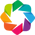

In [5]:
import panel as pn
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')
import somoclu

#SOMToolbox Parser
from SOMToolBox_Parse import SOMToolBox_Parse

idataChainlink = SOMToolBox_Parse("datasets/chainlink/chainlink.vec").read_weight_file()
idataClusters = SOMToolBox_Parse("datasets/10clusters/10clusters.vec").read_weight_file()

### Training for Chainlink

#### with 10x10

In [18]:
n_rows10 = 10
n_columns10 = 10

som = somoclu.Somoclu(n_columns10, n_rows10, compactsupport= False)
som.train(idataChainlink['arr'], epochs=1000)
res_weights_chainlink10 = som.codebook

#### with 100x60

In [7]:
n_rows100 = 100
n_columns100 = 60

som = somoclu.Somoclu(n_columns100, n_rows100, compactsupport= False)
som.train(idataChainlink['arr'], epochs=1000)
res_weights_chainlink100 = som.codebook

### Training for 10-Clusters

#### with 10x10

In [14]:
n_rows10 = 10
n_columns10 = 10

som = somoclu.Somoclu(n_columns10, n_rows10, compactsupport= False)
som.train(idataClusters['arr'], epochs=1000)
res_weights_clusters10 = som.codebook

#### with 100x60

In [9]:
n_rows100 = 100
n_columns100 = 60

som = somoclu.Somoclu(n_columns100, n_rows100, compactsupport= False)
som.train(idataClusters['arr'], epochs=1000)
res_weights_clusters100 = som.codebook

## Visualization of trained SOMs


### Visualization of Chainlink

#### with 10x10

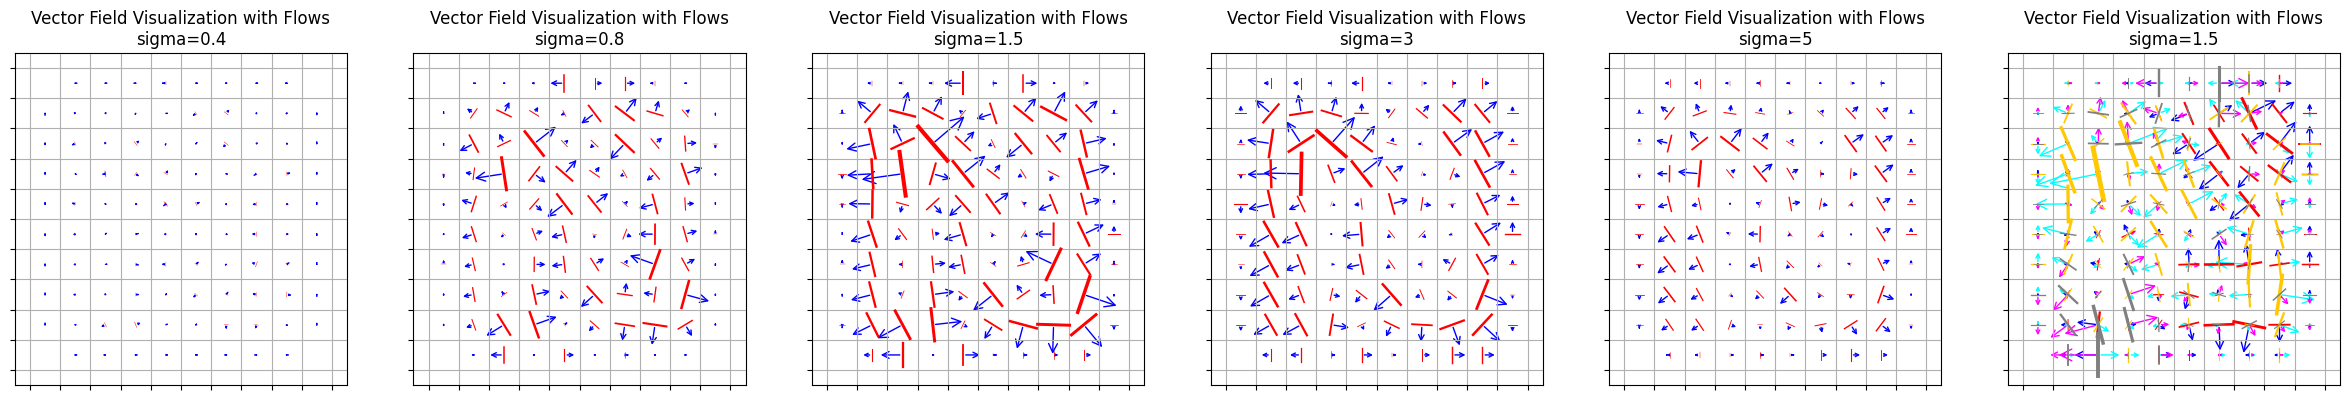

In [19]:
visualize_vector_field(n_rows10, n_columns10, res_weights_chainlink10, idataChainlink['vec_dim'], [
	Config([[0,1,2]], 0.4, True, True, 5), 
	Config([[0,1,2]], 0.8, True, True, 5), 
	Config([[0,1,2]], 1.5, True, True, 5), 
	Config([[0,1,2]], 3, True, True, 5), 
	Config([[0,1,2]], 5, True, True, 5), 
	Config([[0],[1],[2]], 1.5, True, True, 5)])

The small SOM slightly shows the structure of the chainlink model.  
The best sigma here is probably between 1.5 and 3.  
Due to the small size, it's not very accurate. 

#### with 100x60

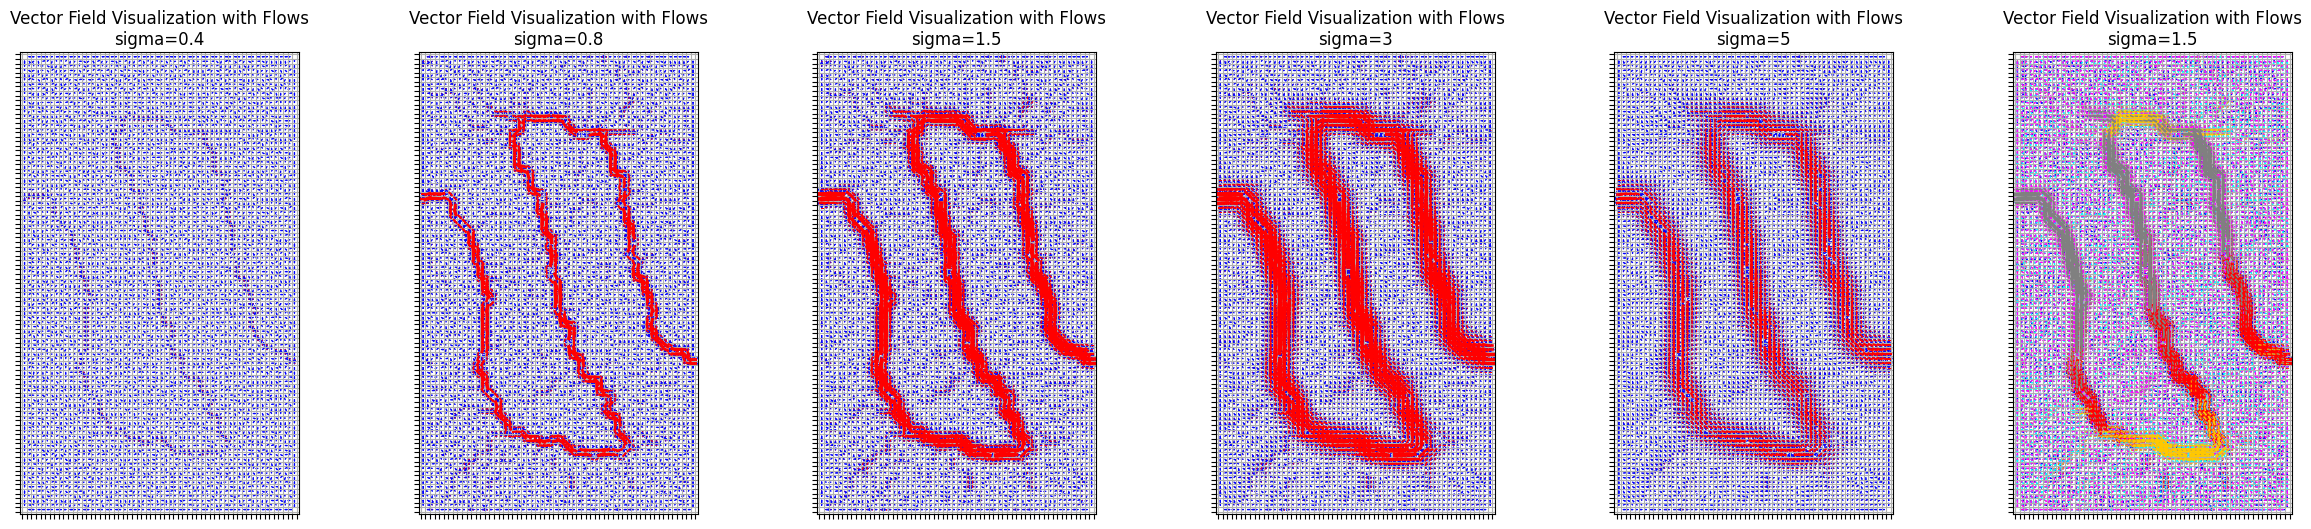

In [52]:
visualize_vector_field(n_rows100, n_columns100, res_weights_chainlink100, idataChainlink['vec_dim'], [
	Config([[0,1,2]], 0.4, True, True, 5), 
	Config([[0,1,2]], 0.8, True, True, 5), 
	Config([[0,1,2]], 1.5, True, True, 5), 
	Config([[0,1,2]], 3, True, True, 5), 
	Config([[0,1,2]], 5, True, True, 5), 
	Config([[0],[1],[2]], 1.5, True, True, 5)])

With the larger SOM, the structure is clearly visible.  
A minimum sigma value of 0.8 should be used to show a good separation.  
Beyond 1.5, it's just too much and the visualization becomes unclear. 


### Visualization of 10-Clusters

#### with 10x10

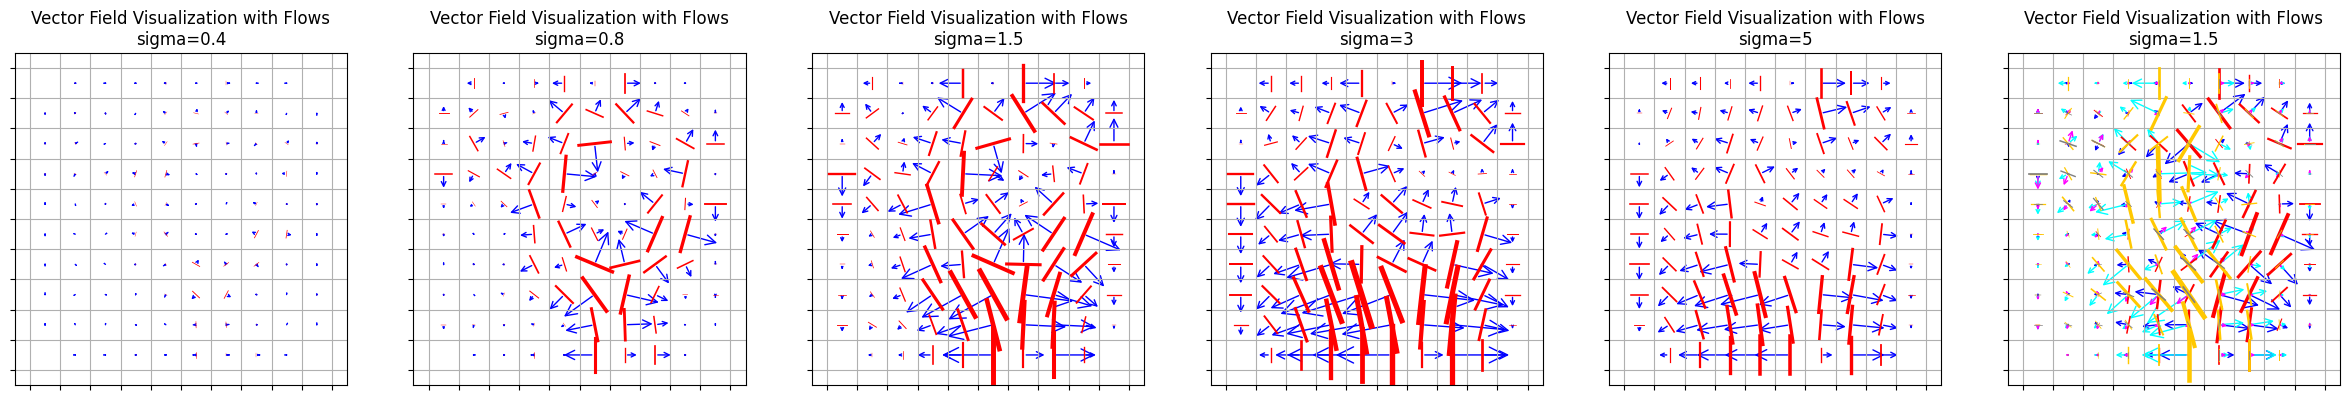

In [53]:
visualize_vector_field(n_rows10, n_columns10, res_weights_clusters10, idataClusters['vec_dim'], [
	Config([[0,1,2]], 0.4, True, True, 1), 
	Config([[0,1,2]], 0.8, True, True, 1), 
	Config([[0,1,2]], 1.5, True, True, 1), 
	Config([[0,1,2]], 3, True, True, 1), 
	Config([[0,1,2]], 5, True, True, 1), 
	Config([[0],[1],[2]], 1.5, True, True, 1)])

The 10-clusters model is way to complex for a 10x10 SOM.  
Regardless of the sigma value, the SOM doesn't really show any usefull information.  
If you know how it should look like, you can kind of see at least the biggest cluster, but aside from that, the SOM is too small. 

#### with 100x60

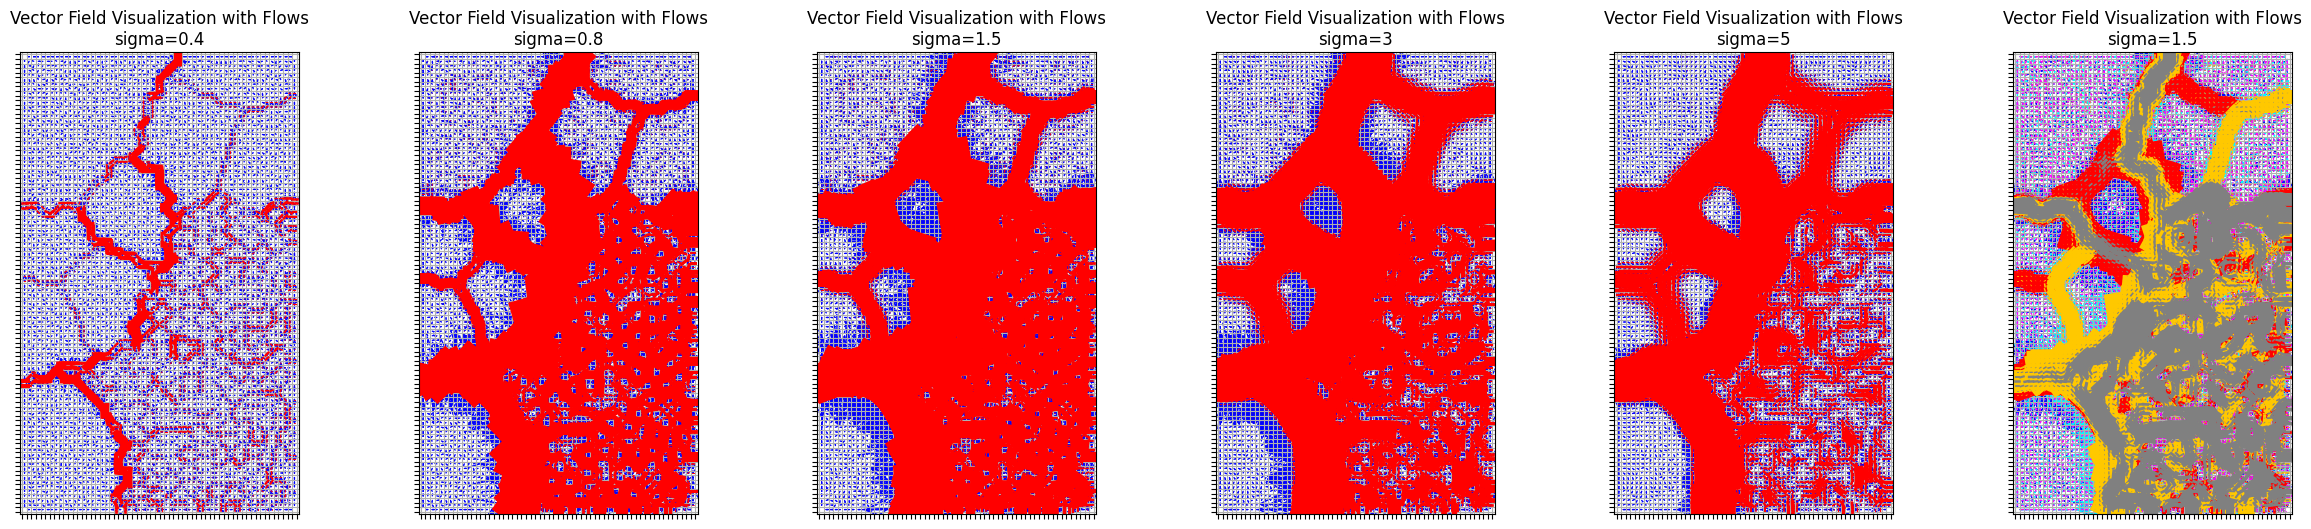

In [54]:
visualize_vector_field(n_rows100, n_columns100, res_weights_clusters100, idataClusters['vec_dim'], [
	Config([[0,1,2]], 0.4, True, True, 5), 
	Config([[0,1,2]], 0.8, True, True, 5), 
	Config([[0,1,2]], 1.5, True, True, 5), 
	Config([[0,1,2]], 3, True, True, 5), 
	Config([[0,1,2]], 5, True, True, 5), 
	Config([[0],[1],[2]], 1.5, True, True, 5)])

Depending of what information you would like to extract from the SOM, a different sigma value might be more useful.  
0.4 shows softer boundaries, but the biggest cluster is kind of a mess.  
With greater sigma values the boundaries become more dense, but it's also easier to separate the biggest cluster from the rest. 

## Comparison with the Java Toolbox

### Our visualization

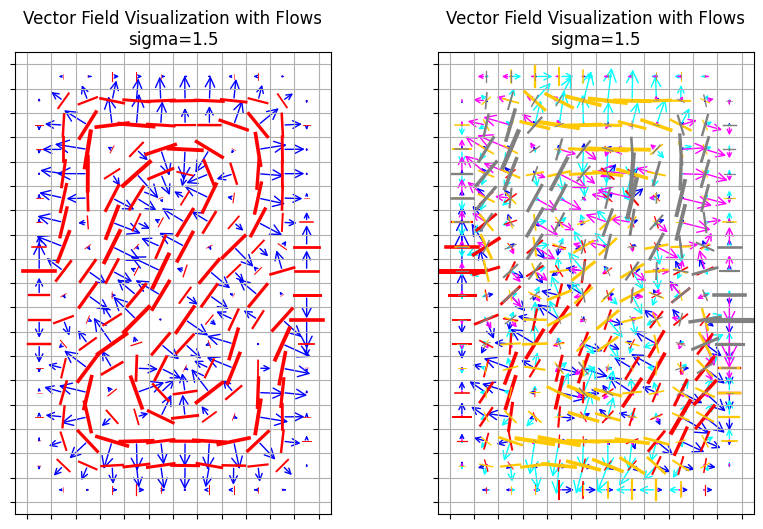

In [55]:
chainWeights  = SOMToolBox_Parse("chainlink_from_java.wgt").read_weight_file()
n_rows = chainWeights['ydim']
n_columns = chainWeights['xdim']

visualize_vector_field(n_rows,n_columns, chainWeights['arr'], chainWeights['vec_dim'], [
	Config([[0,1,2]], 1.5, True, True, 10), 
	Config([[0],[1],[2]], 1.5, True, True, 10)])

### Java Toolbox visualization

![Toolbox result for sigma=1.5, 1 group](/workspaces/SOS_3/PySOMVis/img/sig1.5.PNG)
![Toolbox result for sigma=1.5, 3 groups](/workspaces/SOS_3/PySOMVis/img/sig1.5_each_dim_a_group.PNG)

Even though the visualizations are not exactly the same, probably due to some implementation differences, they both show the chainlink model quite accurately.  
To make it easier to compare the visualizations, we decided to use the same colors as the Java Toolbox. 